# Imports

In [1]:
import pandas as pd
import numpy as np
import re
import string
import json
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import spacy

import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,\
classification_report, accuracy_score, precision_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,\
HashingVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

_________________

**Helper Functions**

In [6]:
def confusion_matrix_plot(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    return plt.show()

def report(y_true, y_pred, class_names=['no_spoiler', 'spoiler']):
    print(classification_report(y_true, y_pred, target_names=class_names))
    confusion_matrix_plot(y_true, y_pred, class_names)

_________

Skip to section 2.3 to load the large dataframe. Then we can run all cells in the remainder of section 2 as well as sections 3 and 4.

To save we can also skip to section 7 and load the review dataframe (with original and lemmatized reviews) and the summaries dataframe for current modeling.

# EDA

## Movie Details

In [ ]:
movie_details = pd.read_json('./data/IMDB_movie_details.json', lines=True)
display(movie_details.info())
movie_details

Convert 'release_date' to a datetime object

In [ ]:
movie_details['release_date'] = pd.to_datetime(movie_details.release_date)

Convert duration into a minute count (integer)

In [ ]:
hour = re.compile('(\d+)h')
minute = re.compile('(\d+)min')

def duration_convert(df):
    # set intial duration to 0
    duration = 0
    # find number of hours and minutes
    hour_found = hour.findall(df.duration)
    minute_found = minute.findall(df.duration)
    # if hours, multiply value by 60 and add to duration
    if hour_found:
        duration += 60 * int(hour_found[0])
    # if minutes, add to duration
    if minute_found:
        duration += int(minute_found[0])
    # return total number of minutes
    return duration

movie_details['duration'] = movie_details.apply(duration_convert, axis=1)

Confirm that genre contains lists for possible future genre analysis

In [ ]:
for i in list(range(len(movie_details))):
    count = 0
    if str(type(movie_details.iloc[i].genre)) != "<class 'list'>":
        count += 1
        print(type(movie_details.iloc[i].genre))
print(f"There are {count} entries for genre that are not a list")

_____________
Check on how many empty plot summary/synopsis there are

In [ ]:
empty_summary = len(movie_details[movie_details.plot_summary == ''])
empty_synopsis = len(movie_details[movie_details.plot_synopsis == ''])
print(f"There are {empty_summary} entries with an empty summary.\nThere are {empty_synopsis} entries with an empty synopsis.")

In [ ]:
first_summary_len = len(movie_details.iloc[0].plot_summary)
first_synopsis_len = len(movie_details.iloc[0].plot_synopsis)
print(f"The first entry summary length is: {first_summary_len}\nThe first entry synopsis length is: {first_synopsis_len}")

The first entry's summary and synopsis reveals that the former is shorter than the latter, which is the field containing some missing values. Checking the whole dataframe to see if that relationship is always the case.

In [ ]:
count = 0

for i in list(range(len(movie_details))):
    summary_len = len(movie_details.iloc[i].plot_summary)
    synopsis_len = len(movie_details.iloc[i].plot_synopsis)
    if summary_len > synopsis_len:
        count += 1

difference = count - empty_synopsis
    
print(f"There are {count} entries where the summary length is greater than the synopsis length.")
print(f"There are {difference} of these entries that contain a synopsis.")

With that many missing, we will use the film summary instead of synopsis.
____________
The quantity of unique values from movie_reviews' movie_id match the number of films we have in the movie details. Some of the movie_id values in the movie_details dataframe have a trailing '/' character which will affect matching when we merge the two dataframes.

In [ ]:
def fix_movie_id(df):
    if df.movie_id[-1] == '/':
        return  df.movie_id[:-1]
    else:
        return df.movie_id

movie_details['movie_id'] = movie_details.apply(fix_movie_id, axis=1)

### Entity extraction of film summary

In [ ]:
# def summary_entities(row):
#     # get the film summary
#     summary = row.plot_summary
#     # generate new features for character and word count of the summary
#     row['summary_char_count'] = len(summary)
#     row['summary_word_count'] = len(summary.split(' '))
#     # get the entities with spacy
#     doc = nlp(summary)
#     # initialize list of entities and their counts
#     ent_list = []
#     ent_count = []
#     # append each entity to the list of entities
#     for ent in doc.ents:
#         ent_list.append(ent.text)
#     # generate the set of unique entities
#     ent_set = set(ent_list)
#     # append a tuple to ent_count with each found entity and its count
#     for ent in ent_set:
#         ent_count.append((ent, ent_list.count(ent)))
#     # set number of unique entities and initialize the total count to 0
#     unique_ents = len(ent_count)
#     unique_ent_count = 0
#     # for each tuple, add the count from the entity frequency to the total count
#     for x in ent_count:
#         unique_ent_count += x[1]
#     # get the average count for an entity
#     if unique_ents != 0:
#         avg_count = round(unique_ent_count / unique_ents, 2)
#     else:
#         avg_count = 0
#     # generate new features for the total entity count, unique count, and avg frequency
#     row['summary_entity_count'] = len(ent_list)
#     row['summary_unique_entities'] = unique_ents
#     row['summary_avg_entity_freq'] = avg_count
#     # return the row
#     return row

# movie_details = movie_details.apply(summary_entities, axis=1)

### Tokenize film summary

In [ ]:
# summary_stopwords = stopwords.words('english')
# pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
# tokenizer = RegexpTokenizer(pattern)

# def summary_tokenize(row):
#     # get the film summary
#     summary = row.plot_summary
#     # tokenize
#     summary_tokens = tokenizer.tokenize(summary)
#     summary_tokens = [token.lower() for token in summary_tokens]
#     summary_tokens = [token for token in summary_tokens if token not in summary_stopwords]
#     # set new feature to token list
#     row['summary_tokens'] = summary_tokens
#     row['summary_token_count'] = len(summary_tokens)
#     return row

# movie_details = movie_details.apply(summary_tokenize, axis=1)

## Movie Reviews

In [ ]:
movie_reviews = pd.read_json('./data/IMDB_reviews.json', lines=True)
display(movie_reviews.info())
movie_reviews

In [ ]:
unique_movies_in_reviews = movie_reviews.movie_id.nunique()
print(f"There are {len(movie_details)} entries in movie_details and {unique_movies_in_reviews} unique movie_id's in movie_reviews")

Converting the review_date to datetime

In [ ]:
movie_reviews['review_date'] = pd.to_datetime(movie_reviews.review_date)

In [ ]:
movie_reviews.describe(datetime_is_numeric=True)

### Entity extraction of reviews

This processing takes just under 8 hours.

In [ ]:
# nlp = spacy.load('en_core_web_sm')

# def entity_info(row):
#     # get the review summary
#     review = row.review_text
#     # generate new features for character and word count of the summary
#     row['char_count'] = len(review)
#     row['word_count'] = len(review.split(' '))
#     # get the entities with spacy
#     doc = nlp(review)
#     # initialize list of entities and their counts
#     ent_list = []
#     ent_count = []
#     # append each entity to the list of entities
#     for ent in doc.ents:
#         ent_list.append(ent.text)
#     # generate the set of unique entities
#     ent_set = set(ent_list)
#     # append a tuple to ent_count with each found entity and its count
#     for ent in ent_set:
#         ent_count.append((ent, ent_list.count(ent)))
#     # set number of unique entities and initialize the total count to 0
#     unique_ents = len(ent_count)
#     unique_ent_count = 0
#     # for each tuple, add the count from the entity frequency to the total count
#     for x in ent_count:
#         unique_ent_count += x[1]
#     # get the average count for an entity
#     if unique_ents != 0:
#         avg_count = round(unique_ent_count / unique_ents, 2)
#     else:
#         avg_count = 0
#     # generate new features for the total entity count, unique count, and avg frequency
#     row['entity_count'] = len(ent_list)
#     row['unique_entities'] = unique_ents
#     row['avg_entity_freq'] = avg_count
#     # return the row
#     return row

# movie_reviews = movie_reviews.apply(entity_info, axis=1)

### Tokenize reviews

In [ ]:
# summary_stopwords = stopwords.words('english')
# pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
# tokenizer = RegexpTokenizer(pattern)

# def review_tokenize(row):
#     # get the film review
#     review = row.review_text
#     # tokenize
#     review_tokens = tokenizer.tokenize(review)
#     review_tokens = [token.lower() for token in review_tokens]
#     review_tokens = [token for token in review_tokens if token not in summary_stopwords]
#     # set new feature to token list
#     row['review_tokens'] = review_tokens
#     row['review_token_count'] = len(review_tokens)
#     return row

# movie_reviews = movie_reviews.apply(review_tokenize, axis=1)

## Merging details and reviews

In [ ]:
# merged_df = pd.merge(movie_details, movie_reviews, on='movie_id', how="right")

# corrected_columns = ['movie_id', 'plot_summary', 'duration', 'genre', 'film_rating',
#                      'release_date', 'plot_synopsis', 'summary_char_count',
#                      'summary_word_count', 'summary_entity_count', 'summary_unique_entities',
#                      'summary_avg_entity_freq', 'summary_tokens', 'summary_token_count',
#                      'review_date', 'user_id', 'is_spoiler', 'review_text', 'reviewer_rating',
#                      'review_summary', 'review_char_count', 'review_word_count', 'review_entity_count',
#                      'review_unique_entities', 'review_avg_entity_freq', 'review_tokens',
#                      'review_token_count']

# merged_df.columns = corrected_columns

# merged_df.to_parquet('./data/full_dataframe.parquet')

This cell reads in the full dataframe from the saved parquet file. The file is large, 573,913 entries with 27 features, takes up about 1.9 GB of space. The load takes about a minute

In [ ]:
merged_df = pd.read_parquet('./data/full_dataframe.parquet')

In [ ]:
merged_df.info()

In [ ]:
merged_df['is_spoiler'] = merged_df.is_spoiler.astype(int)

In [ ]:
merged_df[merged_df.is_spoiler == 1].describe()

In [ ]:
merged_df[merged_df.is_spoiler == 0].describe()

## Explore spoilers vs non-spoilers

Initial observations from the describe calls on reviews marked as spoiler versus ones that are not:
- The reviewer rating is about half a point lower on average for reviews marked as spoilers
- The review word count of a spoiler review is longer on average by about 44% (232 -> 335), but does have a more variation
- Rougly the same can be said about the entity counts (raw and unique)

It looks like there is nothing glaringly obvious about the difference between spoiler and non-spoiler reviews

### frequency

In [ ]:
merged_df.groupby('is_spoiler').size().plot(kind='pie')

### by genre

Pull just the genre feature along with the target 'is_spoiler' so that each film is represented in each genre it's a part of.

In [ ]:
genres = merged_df[['genre', 'is_spoiler']].explode('genre').copy()

In [ ]:
genres.groupby(['genre', 'is_spoiler']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,8));

In [ ]:
genre_breakdown = genres.groupby(['genre', 'is_spoiler']).size().unstack()
# genre_breakdown['percent_true'] = genre_breakdown.apply(lambda x: x..True / (x.True + x.False))

In [ ]:
genre_breakdown

### by user ID

In [ ]:
user_ids = merged_df[['user_id', 'is_spoiler']].copy()
user_ids.user_id.value_counts()

In [ ]:
user_ids.user_id.value_counts().values.sum() / len(user_ids.user_id.value_counts())

There are 263,407 unique users represented in the data. We can see that the vast majority do not comment more than once. The average number of comments is 2.17. Lets look at our top 20 commenters.

In [ ]:
user_id_split_df = user_ids.groupby(['user_id', 'is_spoiler']).size().unstack().sort_values(by=0, ascending=False)
user_id_split_df.
user_id_split_df[:20]

There are some null values where the user only has comments of one target class or the other. We will set them to zero

In [ ]:
user_id_split_df.fillna(0.0, inplace=True)

In [ ]:
testing = user_id_split_df.reset_index()
testing.columns = ['user_id', 'non_spoiler', 'spoiler']
testing

In [ ]:
def total_and_percent(row):
    
    total = row.non_spoiler + row.spoiler
    row['total'] = total
    
    if row.non_spoiler == 0.0:
        row['percent_spoiled'] = 1.0
        
    else:
        row['percent_spoiled'] = row.spoiler / total
        
    return row

In [ ]:
testing = testing.apply(total_and_percent, axis=1)

In [ ]:
testing[testing.total > 5.0].sort_values(by='percent_spoiled', ascending=False)[:20]

In [ ]:
# top 20 reviewers by total count, separated into spoiler/non
user_ids.groupby(['user_id', 'is_spoiler']).size().unstack().sort_values(by=0, ascending=False)[:20].plot(kind='bar', stacked=True, figsize=(15,8));

In [ ]:
test_df = merged_df.groupby('is_spoiler').apply(lambda x: x.sample(frac=0.01))
test_df.reset_index(drop=True, inplace=True)

# Non-language feature modeling

Features which don't pertain to the summary or review text include:
- film duration
- genre
- rating
- release date
- review date
- is_spoiler (target)

In [ ]:
non_lang_features = ['duration', 'genre', 'film_rating', 'release_date', 'review_date',
                     'is_spoiler']
non_language_df = merged_df[non_lang_features].copy()

Engineer a new feature: age of film at review

In [ ]:
def film_age(df):
    age = df.review_date - df.release_date
    return age.days

non_language_df['days_since_release'] = non_language_df.apply(film_age, axis=1)
non_language_df.drop(['release_date', 'review_date'], axis=1, inplace=True)

Encode the genres. [Inspiration](https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list)

In [ ]:
s = non_language_df['genre'].explode()
non_language_df = non_language_df[['duration', 'film_rating', 'is_spoiler',
                                   'days_since_release']].join(pd.crosstab(s.index, s))

## SGD Classifier

![image info](https://scikit-learn.org/stable/_static/ml_map.png)

We are going to try using a SGD classifer to see how well it performs

In [ ]:
# set X and y
X = non_language_df.drop('is_spoiler', axis=1)
y = non_language_df['is_spoiler']

# perform train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# scale the predictors
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

Performing a grid search for optimized parameters. This runs in about 18 minutes, so it's commented out and the best parameters are listed below

In [ ]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet", "none"],
}

clf = SGDClassifier(max_iter=1000)
grid = GridSearchCV(clf, param_grid=params, cv=10, n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)

Best params were:
- alpha: 0.0001
- loss: 'hinge'
- penalty: 'l2'

In [ ]:
sgd_model = SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2')
sgd_model.fit(X_train_s, y_train)

In [ ]:
y_pred = sgd_model.predict(X_test_s)

In [ ]:
report(y_test, y_pred)

Modeling on the film review metadata we have does not look promising.

# Baseline Model

Our baseline model is going to say that any review that contains the word "spoiler" is, in-fact, a spoiler.

In [ ]:
# make a baseline dataframe with just the target and the review_text
baseline_df = merged_df[['is_spoiler', 'review_text']].copy()

# create a new boolean value for reviews that contain the word 'spoiler'
baseline_df['contains_spoiler'] = baseline_df.review_text.str.contains('spoiler')
baseline_df['contains_spoiler'] = baseline_df.contains_spoiler.astype(int)

In [ ]:
report(baseline_df.is_spoiler, baseline_df.contains_spoiler)

Baseline accuracy is about 74%, which sounds great, but the recall on spoilers is very low. The amount of false negatives is staggeringly high. Interestingly, there are lots of films whose review contains the word 'spoiler' but are not marked as such. That could something as simple as a user stating 'No spoilers follow', but it does seem curious to have that many film reviews that aren't spoilers.

# Bag of Words Model

Pulling the summaries into one dataframe and the reviews into another, retaining the movie_id for eventual combination.

The lemmatizing of the reviews done in 5.1 takes about an hour and a half, so to save time we processed it and save the files as parquet files. All we need to do is import the files.

In [4]:
# these lines are the original creation of the dataframes
# summary_df = merged_df[['movie_id', 'plot_summary']].copy()
# summary_df.drop_duplicates(inplace=True)
# summary_df.reset_index(drop=True, inplace=True)
# review_df = merged_df[['movie_id', 'review_text', 'is_spoiler']].copy()

# loading the reviews, contains both original and lemmed field
review_df = pd.read_parquet('./data/reviews_lemmed.parquet')
# loading the summaries
summary_df = pd.read_parquet('./data/plot_summary.parquet')

_________
Setting up a testing Dataframe to ensure things work before applying to all data. It's 1/1000th of the size, so any processing times multiply by 1000 and that will give the estimated time for application to the whole dataset

In [5]:
test_df = review_df.groupby('is_spoiler').apply(lambda x: x.sample(frac=0.001))
test_df.reset_index(drop=True, inplace=True)
test_df

,movie_id,review_text,is_spoiler,review_text_lemmed
0,tt0195685,I did watched this movie because I dearly love...,0,watched movie dearly love julia robert know gr...
1,tt0414387,This movie is terrible. I was so bored I liter...,0,movie terrible bore literally check dvd player...
2,tt0110912,I've always wanted to put this film's parts in...,0,i've always want put film's part order strange...
3,tt0125664,If you believe that the Academy shunned Jim Ca...,0,believe academy shun jim carrey yet another ti...
4,tt0203259,I have been watching this show since their fir...,0,watch show since first season always want help...
...,...,...,...,...
569,tt0322259,I didn't like part one of this because it had ...,1,like part one horrible actor horrible direct b...
570,tt0078788,**Spoilers**I first saw AN on TV while I was i...,1,spoiler first saw tv high school find interest...
571,tt0080678,Easily David Lynch's most accessible film and ...,1,easily david lynch's accessible film undoubted...
572,tt2322441,(I have to mention that my review contains spo...,1,mention review contain spoiler read complete t...


## lemmatization (already processed)

This was performed once and then the dataframe was saved. It's left here in case we need to modify and reprocess the lemmatization.

In [ ]:
sw = stopwords.words('english')
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
tokenizer = RegexpTokenizer(r"([a-zA-Z]+(?:[’'][a-z]+)?)")
lemmatizer = nltk.stem.WordNetLemmatizer()

# helper function to correctly format the part of speech
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# helper function to clean and lemmatize the review
def lem_review(df):
    # get the review text
    doc = df.review_text
    # tokenize the review, lowercase all words and remove stopwords
    doc = tokenizer.tokenize(doc)
    doc = [token.lower() for token in doc]
    doc = [token for token in doc if token not in sw]
    # tag part of speach and convert format of tagging
    doc_tagged = pos_tag(doc)
    doc_tagged = [(token[0], get_wordnet_pos(token[1])) for token in doc_tagged]
    # lemmatize the review
    doc_lemmed = [lemmatizer.lemmatize(token[0], token[1]) for token in doc_tagged]
    # join the lemmas together as a string
    doc_cleaned = ' '.join(doc_lemmed)
    # return the cleaned review
    return doc_cleaned

In [ ]:
# this takes about an hour and a half
# review_df['review_text_lemmed'] = review_df.apply(lem_review, axis=1)

# because it took so long, we are going to save it to a parquet file
# review_df.to_parquet('./data/reviews_lemmed.parquet')

# we are also saving the summary dataframe as well to save time
# summary_df.to_parquet('./data/plot_summary.parquet')

## set train/val/test

In [7]:
# set X to the review text lemmed, y to target
X = review_df.review_text_lemmed
y = review_df.is_spoiler

# We want 20% of our data for test and 20% for validation, generate our holdout number
holdout = round(len(X) * 0.2)

In [8]:
# do first train/test split for train/val set and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, random_state=42, test_size=holdout)

# perform 2nd train/test split (on train/val) for train and val sets
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=42, test_size=holdout)

# confirm shapes
print(f"X_train / y_train shapes: {X_train.shape}, {y_train.shape}")
print(f"X_val / y_val shapes: {X_val.shape}, {y_val.shape}")
print(f"X_test / y_test shapes: {X_test.shape}, {y_test.shape}")

X_train / y_train shapes: (344347,), (344347,)
X_val / y_val shapes: (114783,), (114783,)
X_test / y_test shapes: (114783,), (114783,)


## first model - MNB, base tfidf vectorizer

In [9]:
# set tfidf vectorizer
tf_vec_v1 = TfidfVectorizer()

# fit/transfrom X_train, convert to dataframe and set columns/index
X_train_vec_v1 = tf_vec_v1.fit_transform(X_train)
X_train_vec_v1 = pd.DataFrame.sparse.from_spmatrix(X_train_vec_v1)
X_train_vec_v1.columns = sorted(tf_vec_v1.vocabulary_)
X_train_vec_v1.set_index(y_train.index, inplace=True)

# transform X_val, convert to dataframe and set columns/index
X_val_vec_v1 = tf_vec_v1.transform(X_val)
X_val_vec_v1  = pd.DataFrame.sparse.from_spmatrix(X_val_vec_v1)
X_val_vec_v1.columns = sorted(tf_vec_v1.vocabulary_)
X_val_vec_v1.set_index(y_val.index, inplace=True)

In [10]:
len(tf_vec_v1.vocabulary_)

198034

In [ ]:
# This section can be uncommented to use count vectorizer instead
# set count vectorizer
# c_vec = CountVectorizer()

# fit/transfrom X_train, convert to dataframe and set columns/index
# X_train_vec = c_vec.fit_transform(X_train)
# X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
# X_train_vec.columns = sorted(tf_vec.vocabulary_)
# X_train_vec.set_index(y_train.index, inplace=True)

# transform X_val, convert to dataframe and set columns/index
# X_val_vec = c_vec.transform(X_val)
# X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
# X_val_vec.columns = sorted(c_vec.vocabulary_)
# X_val_vec.set_index(y_val.index, inplace=True)

In [11]:
# instantiate multinomial naive bayes model
mnb = MultinomialNB()

# fit to X_train_vec/y_train
mnb.fit(X_train_vec_v1, y_train)

# generate y_pred
y_pred_v1 = mnb.predict(X_val_vec_v1)

              precision    recall  f1-score   support

  no_spoiler       0.74      1.00      0.85     84751
     spoiler       0.77      0.02      0.05     30032

    accuracy                           0.74    114783
   macro avg       0.76      0.51      0.45    114783
weighted avg       0.75      0.74      0.64    114783



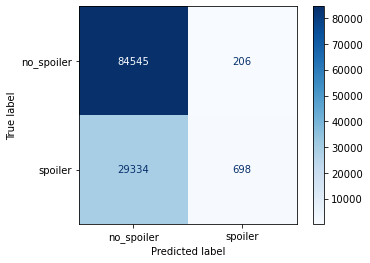

In [12]:
report(y_val, y_pred_v1)

## second model - MNB add bigrams, min occurance 5

In [13]:
test_df = review_df.groupby('is_spoiler').apply(lambda x: x.sample(frac=0.001))
test_df.reset_index(drop=True, inplace=True)
test_df

,movie_id,review_text,is_spoiler,review_text_lemmed
0,tt3530002,I'm a pretty tough critic when it comes to mov...,0,i'm pretty tough critic come movie general com...
1,tt2304933,Bad on every variable/level/potential area for...,0,bad every variable level potential area type c...
2,tt0309698,It's really a little bit weird at the beginnin...,0,really little bit weird begin thought murder t...
3,tt0115798,"When first released, Cable Guy was such an unu...",0,first release cable guy unusual departure jim ...
4,tt0430912,"LESS MAJESTIC than it's predecessor,BI2 came o...",0,less majestic predecessor bi come year later w...
...,...,...,...,...
569,tt2140479,In this silly convoluted tale that seems to ta...,1,silly convolute tale seem take place vacuum so...
570,tt0114814,"This film is basically a dark, sophisticated '...",1,film basically dark sophisticated caper thrill...
571,tt0075686,The way woody Allen tells the story of his cha...,1,way woody allen tell story character's relatio...
572,tt2872732,I really liked this film. I'll go ahead and gi...,1,really like film i'll go ahead give example co...


In [14]:
test_vec = TfidfVectorizer()

test_df_vec = test_vec.fit_transform(test_df['review_text_lemmed'])
test_df_vec = pd.DataFrame.sparse.from_spmatrix(test_df_vec)
test_df_vec.columns = sorted(test_vec.vocabulary_)
# test_df_vec.set_index()

test_df_vec

,aamir,aang,aaron,abandon,abandonment,abba,abbie,abc,abduction,abe,...,zoe,zohan,zombie,zone,zooey,zoolander,zoom,zubrowka,zuckerberg,zuko
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# set tfidf vectorizer
tf_vec_v2 = TfidfVectorizer(min_df=5, ngram_range=(1,2))

# fit/transfrom X_train, convert to dataframe and set columns/index
X_train_vec_v2 = tf_vec_v2.fit_transform(X_train)
X_train_vec_v2 = pd.DataFrame.sparse.from_spmatrix(X_train_vec_v2)
X_train_vec_v2.columns = sorted(tf_vec_v2.vocabulary_)
X_train_vec_v2.set_index(y_train.index, inplace=True)

# transform X_val, convert to dataframe and set columns/index
X_val_vec_v2 = tf_vec_v2.transform(X_val)
X_val_vec_v2 = pd.DataFrame.sparse.from_spmatrix(X_val_vec_v2)
X_val_vec_v2.columns = sorted(tf_vec_v2.vocabulary_)
X_val_vec_v2.set_index(y_val.index, inplace=True)

In [ ]:
X_train_vec_v2

In [ ]:
# instantiate multinomial naive bayes model
mnb_v2 = MultinomialNB()

# fit to X_train_vec/y_train
mnb_v2.fit(X_train_vec_v2, y_train)

# generate y_pred
y_pred_v2 = mnb_v2.predict(X_val_vec_v2)

In [ ]:
report(y_val, y_pred_v2)

# testing

In [ ]:
vec = CountVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X = vec.fit_transform(test_df.review_text)

df_cv = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
df_cv.head()

In [ ]:
tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X = tf_vec.fit_transform(test_df.review_text)

df = pd.DataFrame(X.toarray(), columns = tf_vec.get_feature_names_out())
df.head()

In [ ]:
test_df.iloc[0].review_text

In [ ]:
df.iloc[0].sort_values(ascending=False)[:10]

In [ ]:
df_cv.iloc[0].sort_values(ascending=False)[:10]